# Object Tracking Using SIFT

This notebook is tied to the previous notebook where I recreated the SIFT detector. Now I'll use the SIFT detector to see if I can track objects or patterns within an image. I'll be using the same traffic video that I did before

In [26]:
import cv2
import numpy as np
from IPython.display import display, Video
from ipywidgets import Output
import matplotlib
from matplotlib import pyplot as plt
from contextlib import contextmanager
from tqdm.notebook import tqdm
from itertools import cycle
from operator import itemgetter
from uuid import UUID, uuid1 as uuid
from dataclasses import dataclass, field
from collections import OrderedDict
import multiprocessing

matplotlib.rcdefaults()
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (16, 12)
matplotlib.rcParams['image.cmap'] = 'gray'
np.set_printoptions(precision=2)

intpl = lambda t: tuple(map(int, t))
take = lambda n, it: map(itemgetter(1), zip(range(n), it))

video_file = '../../data/traffic-video.mp4'
intermediate_file_template = '../../data/traffic-video-{step}.mp4'

Video(video_file)

Let's first see if we can track the grayscale version of the video file. So we'll convert the video to grayscale first. We need to grab the frame size and framerate from our previous capture. Since we'll be writing a lot of video, I'll create some functions to handle most of the common routines

In [9]:
@contextmanager
def video_capture(video_file):
    # Create capture and get params
    capture = cv2.VideoCapture(video_file)
    yield capture
    capture.release()
    
    
@contextmanager
def video_writer(video_file, size, framerate, fourcc='avc1', isColor=True):
    # Create writer with params
    fourcc = cv2.VideoWriter_fourcc(*fourcc)
    writer = cv2.VideoWriter(video_file, fourcc, framerate, size, isColor=isColor)
    yield writer
    writer.release()


@contextmanager
def video_pipe(from_file, to_file, fourcc='avc1', isColor=True):
    with video_capture(from_file) as cap:
        # Get capture params
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        framerate = cap.get(cv2.CAP_PROP_FPS)
        with video_writer(to_file, (width, height), framerate, fourcc, isColor) as wrt:
            yield (cap, wrt)

    
def frame_iter(capture, desc='Processing Frames'):
    frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    progress = tqdm(desc=desc, total=frames)
    has_frames, frame = capture.read()
    while has_frames:
        yield frame
        progress.update()
        has_frames, frame = capture.read()
    

grayscale_file = intermediate_file_template.format(step='grayscale')

# Convert frames to grayscale
with video_pipe(video_file, grayscale_file, isColor=False) as (cap, writer):
    for frame in frame_iter(cap):
        grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        writer.write(grayscale)

# Display new Video
Video(grayscale_file)

Processing Frames:   0%|          | 0/750 [00:00<?, ?it/s]

Before we apply OpenCV's SIFT detector to each frame, we need to mask out the parts of the image we want to focus on, i.e. the cars driving on the road.

In [10]:
# Road line boundary
r_x1 = 860
r_x2 = 150

masked_file = intermediate_file_template.format(step='masked')

# Get width and height of image
cap = cv2.VideoCapture(grayscale_file)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

# Image pixel space
x,y = np.meshgrid(np.arange(w), np.arange(h))

# Mask
road_mask = x + y * (r_x1 - r_x2) / h - r_x1 > 0
chrmask = ((-x + 665 > 0) \
        | (-y + 640 > 0) \
        | (x - 1155 > 0) \
        | (y - 690 > 0))
track_mask = chrmask & road_mask
track_mask = track_mask.astype(np.uint8)

# Create framed video
with video_pipe(grayscale_file, masked_file, isColor=False) as (cap, writer):
    for frame in frame_iter(cap):
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        masked_frame = np.where(track_mask, gray_frame, 0)
        writer.write(masked_frame)
        
# Display new Video
Video(masked_file)

Processing Frames:   0%|          | 0/750 [00:00<?, ?it/s]

I'm going to draw the points manually as I want to implement my own tracking but still display them. So I created my own colormap to distinguish the different keypoints. All colormap points are displayed neatly below in the grid.

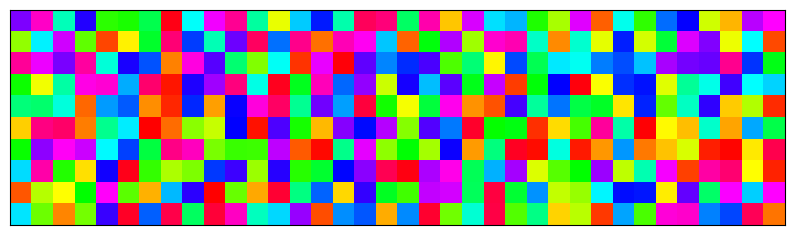

In [11]:
# Create colormap
n_colors = 360
q = n_colors // 6
p = np.linspace(0, 1, q)
w = np.zeros(n_colors + 2*q)
w[2*q:3*q] = p
w[3*q:5*q] = 1.0
w[5*q:6*q] = 1.0 - p
colormap = 255 * np.array([(1.0 - w[q:-q]), w[:-2*q], w[2*q:]]).T
np.random.shuffle(colormap)

# Display colormap as image
imheight = 10
imscale = 1
imwidth = n_colors // imheight
x, y = np.meshgrid(np.arange(imwidth), np.arange(imheight))
image = colormap[(y*imwidth + x),:].astype(np.uint8)
rc_params = {
    'figure.figsize': (imheight*imscale, imwidth*imscale),
    'xtick.bottom': False,
    'xtick.labelbottom': False,
    'ytick.left': False,
    'ytick.labelleft': False
}
with plt.rc_context(rc_params):
    plt.imshow(image)
    plt.show()

# Convert colormap to list of tuples
colormap = list(map(tuple, colormap))

Now we'll run SIFT detection to find all keypoints and descriptors in the frame.

Since I'm working on my own tracking algorithm, I'll use my own keypoint drawing system using the custom colormap above.

In [12]:
keypoints_file = intermediate_file_template.format(step='keypoints')

def draw_keypoints(img, keypoints, colors=cycle(colormap)):
    kpimg = img.copy()
    for kp, color in zip(keypoints, colors):
        r = int(kp.size / 2)
        c = np.array(kp.pt, dtype=np.int32)
        v = np.array([ np.cos(kp.angle), np.sin(kp.angle) ])
        u = (c + r*v).astype(np.uint32)
        cv2.circle(kpimg, c, r, color, 1)
        cv2.arrowedLine(kpimg, c, u, color, 1)
    return kpimg
        
sift = cv2.SIFT.create()
keypoint_data = []

with video_capture(grayscale_file) as cap:
    for frame in frame_iter(cap, desc='Generating Keypoint Data'):
        keypoints, descriptors = sift.detectAndCompute(frame, track_mask)
        keypoint_data.append((keypoints, descriptors))

with video_pipe(grayscale_file, keypoints_file) as (cap, wrt):
    for (keypoints,_), frame in zip(keypoint_data, frame_iter(cap, desc="Drawing Keypoints")):
        keypoints_frame = draw_keypoints(frame, keypoints)
        wrt.write(keypoints_frame)
        
Video(keypoints_file)

Generating Keypoint Data:   0%|          | 0/750 [00:00<?, ?it/s]

Drawing Keypoints:   0%|          | 0/750 [00:00<?, ?it/s]

If we look at these keypoints, we notice they're jittering a lot. That's because each frame is treated independently, and each detection is treated as a new keypoint. We need to correlate each keypoint in a frame with the keypoints in the frame before using a matching algorithm.

We'll use the euclidean distance to match the descriptors of keypoints with each other. For each pair of adjacent frames, we take both sets of descriptors, and attempt to reorder them based on which keypoints match which with the previous frame.

In [63]:
tracked_file = intermediate_file_template.format(step='tracked')
match_threshold = 100.0

def reorder_descriptors(dsc_a, dsc_b):
    """
    Match descriptors in dsc_a with those in
    dsc_b and find required indeces to reorder
    dsc_b to best match dsc_a
    """
    dsc_a = dsc_a[:,np.newaxis,:]
    dsc_b = dsc_b[np.newaxis,:,:]
    distance = np.sum((dsc_a - dsc_b)**2, axis=2)
    p_idx = np.arange(distance.shape[0])
    m_idx = np.argmin(distance, axis=1)
    return np.where(
        distance.min(axis=1) < match_threshold,
        m_idx,
        p_idx)


max_kps = max( len(kp) for kp,_ in keypoint_data )
colors = list(take(max_kps, cycle(colormap)))

# Get max number of keypoints in a given frame
ro_keypoint_data = [ keypoint_data[0] ]

for (kp_list, dsc) in tqdm(keypoint_data[1:], desc='Reordering keypoints'):
    kps = np.array(kp_list)
    last_dsc = ro_keypoint_data[-1][1]
    ro_idx = reorder_descriptors(last_dsc, dsc)
    ro_kps = kps[ro_idx]
    ro_dsc = dsc[ro_idx]
    ro_keypoint_data.append((list(ro_kps), ro_dsc))
    
with video_pipe(grayscale_file, tracked_file) as (cap, wrt):
    for (keypoints,_), frame in zip(ro_keypoint_data, frame_iter(cap, desc="Drawing Keypoints")):
        keypoints_frame = draw_keypoints(frame, keypoints, colors=colors)
        wrt.write(keypoints_frame)
        
Video(tracked_file)

Reordering keypoints:   0%|          | 0/749 [00:00<?, ?it/s]

Drawing Keypoints:   0%|          | 0/750 [00:00<?, ?it/s]